In [1]:
import brian2 as b2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mplib
import pandas as pd
import datetime
import os
import math
import params
import preprocessing
import connectivity
import random
import pickle
import brian2tools as b2tools
from input_factory import get_step_current, get_ou_current
from plot_tools import plot_voltage_and_current_traces

save_data = True

In [2]:
time = 1000 #ms
param_set_exc = params.param_set_exc
param_set_fs  = params.param_set_fs
param_set_nfs = params.param_set_nfs

# reversal potential for COBA synapses
E_exc = 0 * b2.mV
E_inh = -80 * b2.mV

### Setting up and running the initial simulations

In [3]:
# dir = "two_layers_coba"
# run_counter = '2' #'1' for L4 only

# if save_data:
#     if not os.path.exists('result_' + dir):
#             os.makedirs('result_' + dir)
            
#     saving_dir='result_' + dir+'/'+str(run_counter)+'/'
#     if not os.path.exists(saving_dir):
#             os.makedirs(saving_dir)



# 2 --> exc neuron

model_eqs_1 = '''
dv/dt = (-gL_1*(v-v_rest_1) - w1 - w2 + I)/C_1 : volt

dw1/dt = -w1/tau_w1_1 : amp
dw2/dt = -w2/tau_w2_1 : amp

dvt1/dt = -vt1/tau_vt1_1 : volt
dvt2/dt = -vt2/tau_vt2_1 : volt

vt = v_thresh_1 + vt1 + vt2 : volt
lambda_t = lambda_0_1*exp((v-vt)/del_v_1): Hz

I = I_syn + Iexc_ext(t,i) : amp
I_syn = I_exc + I_inh : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp

dg_exc/dt = -g_exc/tau_exc_1: siemens
dg_inh/dt = -g_inh/tau_inh_1 : siemens
'''
reset_eqs_1 = '''
v = v_reset_1
w1+=amp_w1_1
w2+=amp_w2_1
vt1+=amp_vt1_1
vt2+=amp_vt2_1
'''

exc_df = pd.read_csv('data/exc.txt',header = None)
exc_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']


exc_param = exc_df.iloc[param_set_exc,:] #set which value to try out, set any if running through all

lambda_0_1 = 10 * b2.kHz

C_1 = exc_param['C (nF)'] * b2.nF
gL_1 = exc_param['gL (usiemens)'] * b2.usiemens
v_rest_1 = exc_param['v_rest (mV)'] * b2.mV
v_reset_1 = exc_param['v_reset (mV)'] * b2.mV
tau_refr_1 = exc_param['tau_refr (ms)'] * b2.ms

v_thresh_1 = exc_param['v_thresh (mV)'] * b2.mV
del_v_1 = exc_param['del_v (mV)'] * b2.mV
# del_v_1 = 0.1 * b2.mV
amp_w1_1 = exc_param['amp_w1 (nA)'] * b2.nA
tau_w1_1 = exc_param['tau_w1 (ms)'] * b2.ms
amp_w2_1 = exc_param['amp_w2 (nA)'] * b2.nA
tau_w2_1 = exc_param['tau_w2 (ms)'] * b2.ms

amp_vt1_1 = exc_param['amp_vt1 (mV)'] * b2.mV
tau_vt1_1 = exc_param['tau_vt1 (ms)'] * b2.ms
amp_vt2_1 = exc_param['amp_vt2 (mV)'] * b2.mV
tau_vt2_1 = exc_param['tau_vt2 (ms)'] * b2.ms

tau_exc_1 = params.conn_param['L23_L23']['exc_exc']['tau_syn'] * b2.ms
tau_inh_1 = params.conn_param['L23_L23']['fs_exc']['tau_syn'] * b2.ms



## 2 --> fs neuron
model_eqs_2 = '''
dv/dt = (-gL_2*(v-v_rest_2) - w1 - w2 + I)/C_2 : volt

dw1/dt = -w1/tau_w1_2 : amp
dw2/dt = -w2/tau_w2_2 : amp

dvt1/dt = -vt1/tau_vt1_2 : volt
dvt2/dt = -vt2/tau_vt2_2 : volt

vt = v_thresh_2 + vt1 + vt2 : volt
lambda_t = lambda_0_2*exp((v-vt)/del_v_2): Hz

I = I_syn + Ifs_ext(t,i) : amp
I_syn = I_exc + I_inh : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp

dg_exc/dt = -g_exc/tau_exc_2: siemens
dg_inh/dt = -g_inh/tau_inh_2 : siemens
'''
reset_eqs_2 = '''
v = v_reset_2
w1+=amp_w1_2
w2+=amp_w2_2
vt1+=amp_vt1_2
vt2+=amp_vt2_2
'''

fs_df = pd.read_csv('data/fs.txt',header = None)
fs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']


fs_param = fs_df.iloc[param_set_fs,:] #set which value to try out, set any if running through all

lambda_0_2 = 10 * b2.kHz

C_2 = fs_param['C (nF)'] * b2.nF
gL_2 = fs_param['gL (usiemens)'] * b2.usiemens
v_rest_2 = fs_param['v_rest (mV)'] * b2.mV
v_reset_2 = fs_param['v_reset (mV)'] * b2.mV
tau_refr_2 = fs_param['tau_refr (ms)'] * b2.ms

v_thresh_2 = fs_param['v_thresh (mV)'] * b2.mV
del_v_2 = fs_param['del_v (mV)'] * b2.mV
# del_v_1 = 0.1 * b2.mV
amp_w1_2 = fs_param['amp_w1 (nA)'] * b2.nA
tau_w1_2 = fs_param['tau_w1 (ms)'] * b2.ms
amp_w2_2 = fs_param['amp_w2 (nA)'] * b2.nA
tau_w2_2 = fs_param['tau_w2 (ms)'] * b2.ms

amp_vt1_2 = fs_param['amp_vt1 (mV)'] * b2.mV
tau_vt1_2 = fs_param['tau_vt1 (ms)'] * b2.ms
amp_vt2_2 = fs_param['amp_vt2 (mV)'] * b2.mV
tau_vt2_2 = fs_param['tau_vt2 (ms)'] * b2.ms

tau_exc_2 = params.conn_param['L23_L23']['exc_fs']['tau_syn'] * b2.ms
tau_inh_2 = params.conn_param['L23_L23']['fs_fs']['tau_syn'] * b2.ms


# 3 --> nfs neuron
model_eqs_3 = '''
dv/dt = (-gL_3*(v-v_rest_3) - w1 - w2 + I)/C_3 : volt

dw1/dt = -w1/tau_w1_3 : amp
dw2/dt = -w2/tau_w2_3 : amp

dvt1/dt = -vt1/tau_vt1_3 : volt
dvt2/dt = -vt2/tau_vt2_3 : volt

vt = v_thresh_3 + vt1 + vt2 : volt
lambda_t = lambda_0_3*exp((v-vt)/del_v_3): Hz

I = I_syn + Infs_ext(t,i) : amp
I_syn = I_exc + I_inh : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp

dg_exc/dt = -g_exc/tau_exc_3: siemens
dg_inh/dt = -g_inh/tau_inh_3 : siemens
'''
reset_eqs_3 = '''
v = v_reset_3
w1+=amp_w1_3
w2+=amp_w2_3
vt1+=amp_vt1_3
vt2+=amp_vt2_3
'''

nfs_df = pd.read_csv('data/nfs.txt',header = None)
nfs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']


nfs_param = nfs_df.iloc[param_set_nfs,:] #set which value to try out, set any if running through all

lambda_0_3 = 10 * b2.kHz

C_3 = nfs_param['C (nF)'] * b2.nF
gL_3 = nfs_param['gL (usiemens)'] * b2.usiemens
v_rest_3 = nfs_param['v_rest (mV)'] * b2.mV
v_reset_3 = nfs_param['v_reset (mV)'] * b2.mV
tau_refr_3 = nfs_param['tau_refr (ms)'] * b2.ms

v_thresh_3 = nfs_param['v_thresh (mV)'] * b2.mV
del_v_3 = nfs_param['del_v (mV)'] * b2.mV
# del_v_1 = 0.1 * b2.mV
amp_w1_3 = nfs_param['amp_w1 (nA)'] * b2.nA
tau_w1_3 = nfs_param['tau_w1 (ms)'] * b2.ms
amp_w2_3 = nfs_param['amp_w2 (nA)'] * b2.nA
tau_w2_3 = nfs_param['tau_w2 (ms)'] * b2.ms

amp_vt1_3 = nfs_param['amp_vt1 (mV)'] * b2.mV
tau_vt1_3 = nfs_param['tau_vt1 (ms)'] * b2.ms
amp_vt2_3 = nfs_param['amp_vt2 (mV)'] * b2.mV
tau_vt2_3 = nfs_param['tau_vt2 (ms)'] * b2.ms

tau_exc_3 = params.conn_param['L23_L23']['exc_nfs']['tau_syn'] * b2.ms
tau_inh_3 = params.conn_param['L23_L23']['nfs_nfs']['tau_syn'] * b2.ms

#####
I_newexc = np.loadtxt('Iexc.txt') * b2.namp
Iexc_ext = b2.TimedArray(I_newexc, dt = 1.*b2.ms)

I_newfs = np.loadtxt('Ifs.txt') * b2.namp
Ifs_ext = b2.TimedArray(I_newfs, dt = 1.*b2.ms)

I_newnfs = np.loadtxt('Infs.txt') * b2.namp
Infs_ext = b2.TimedArray(I_newnfs, dt = 1.*b2.ms)

####

################ forming populations #############

pops = {}

pops['L23exc'] = b2.NeuronGroup(params.size['L23']['exc'],model=model_eqs_1, reset = reset_eqs_1, threshold = "v > vt", refractory = tau_refr_1, method = 'rk4')
pops['L23fs'] = b2.NeuronGroup(params.size['L23']['fs'],model=model_eqs_2, reset = reset_eqs_2, threshold = "v > vt", refractory = tau_refr_2, method = 'rk4')
pops['L23nfs'] = b2.NeuronGroup(params.size['L23']['nfs'],model=model_eqs_3, reset = reset_eqs_3, threshold = "v > vt", refractory = tau_refr_3, method = 'rk4')


pops['L4exc'] = b2.NeuronGroup(params.size['L4']['exc'],model=model_eqs_1, reset = reset_eqs_1, threshold = "v > vt", refractory = tau_refr_1, method = 'rk4')
pops['L4fs'] = b2.NeuronGroup(params.size['L4']['fs'],model=model_eqs_2, reset = reset_eqs_2, threshold = "v > vt", refractory = tau_refr_2, method = 'rk4')
pops['L4nfs'] = b2.NeuronGroup(params.size['L4']['nfs'],model=model_eqs_3, reset = reset_eqs_3, threshold = "v > vt", refractory = tau_refr_3, method = 'rk4')

## add thalamus
# thalamus = b2.PoissonGroup(600, rates = '(1+sin(t*5*Hz))*7*Hz')

####################################################


################# forming synapses ###################

# inside L4 #

conn_L4exc_L4exc = b2.Synapses(pops['L4exc'], pops['L4exc'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L4exc.connect(p = params.conn_param['L4_L4']['exc_exc']['p'])
conn_L4exc_L4exc.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L4']['exc_exc']['w']*b2.nA, v_rest_1, E_exc)

conn_L4fs_L4fs = b2.Synapses(pops['L4fs'], pops['L4fs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4fs_L4fs.connect(p = params.conn_param['L4_L4']['fs_fs']['p'])
conn_L4fs_L4fs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['fs_fs']['w']*b2.nA, v_rest_2, E_inh)

conn_L4exc_L4fs = b2.Synapses(pops['L4exc'], pops['L4fs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L4fs.connect(p = params.conn_param['L4_L4']['exc_fs']['p'])
conn_L4exc_L4fs.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L4']['exc_fs']['w']*b2.nA, v_rest_2, E_exc)

conn_L4fs_L4exc = b2.Synapses(pops['L4fs'], pops['L4exc'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4fs_L4exc.connect(p = params.conn_param['L4_L4']['fs_exc']['p'])
conn_L4fs_L4exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['fs_exc']['w']*b2.nA, v_rest_1, E_inh)

conn_L4exc_L4nfs = b2.Synapses(pops['L4exc'], pops['L4nfs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L4nfs.connect(p = params.conn_param['L4_L4']['exc_nfs']['p'])
conn_L4exc_L4nfs.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L4']['exc_nfs']['w']*b2.nA, v_rest_3, E_exc)

conn_L4nfs_L4nfs = b2.Synapses(pops['L4nfs'], pops['L4nfs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4nfs_L4nfs.connect(p = params.conn_param['L4_L4']['nfs_nfs']['p'])
conn_L4nfs_L4nfs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['nfs_nfs']['w']*b2.nA, v_rest_3, E_inh)

conn_L4nfs_L4exc = b2.Synapses(pops['L4nfs'], pops['L4exc'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4nfs_L4exc.connect(p = params.conn_param['L4_L4']['nfs_exc']['p'])
conn_L4nfs_L4exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['nfs_exc']['w']*b2.nA, v_rest_1, E_inh)

conn_L4nfs_L4fs = b2.Synapses(pops['L4nfs'], pops['L4fs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L4nfs_L4fs.connect(p = params.conn_param['L4_L4']['nfs_fs']['p'])
conn_L4nfs_L4fs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['nfs_fs']['w']*b2.nA, v_rest_2, E_inh)

## inside L23
conn_L23exc_L23exc = b2.Synapses(pops['L23exc'], pops['L23exc'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L23exc_L23exc.connect(p = params.conn_param['L23_L23']['exc_exc']['p'])
conn_L23exc_L23exc.w = preprocessing.CUBA_to_COBA(params.conn_param['L23_L23']['exc_exc']['w']*b2.nA, v_rest_1, E_exc)

conn_L23exc_L23nfs = b2.Synapses(pops['L23exc'], pops['L23nfs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L23exc_L23nfs.connect(p = params.conn_param['L23_L23']['exc_nfs']['p'])
conn_L23exc_L23nfs.w = preprocessing.CUBA_to_COBA(params.conn_param['L23_L23']['exc_nfs']['w']*b2.nA, v_rest_3, E_exc)

conn_L23exc_L23fs = b2.Synapses(pops['L23exc'], pops['L23fs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L23exc_L23fs.connect(p = params.conn_param['L23_L23']['exc_fs']['p'])
conn_L23exc_L23fs.w = preprocessing.CUBA_to_COBA(params.conn_param['L23_L23']['exc_nfs']['w']*b2.nA, v_rest_2, E_exc)

conn_L23fs_L23exc = b2.Synapses(pops['L23fs'], pops['L23exc'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23fs_L23exc.connect(p = params.conn_param['L23_L23']['fs_exc']['p'])
conn_L23fs_L23exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['fs_exc']['w']*b2.nA, v_rest_1, E_inh)

conn_L23fs_L23nfs = b2.Synapses(pops['L23fs'], pops['L23nfs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23fs_L23nfs.connect(p = params.conn_param['L23_L23']['fs_nfs']['p'])
conn_L23fs_L23nfs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['fs_nfs']['w']*b2.nA, v_rest_3, E_inh)

conn_L23fs_L23fs = b2.Synapses(pops['L23fs'], pops['L23fs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23fs_L23fs.connect(p = params.conn_param['L23_L23']['fs_exc']['p'])
conn_L23fs_L23fs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['fs_fs']['w']*b2.nA, v_rest_2, E_inh)

conn_L23nfs_L23exc = b2.Synapses(pops['L23nfs'], pops['L23exc'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23nfs_L23exc.connect(p = params.conn_param['L23_L23']['nfs_exc']['p'])
conn_L23nfs_L23exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['nfs_exc']['w']*b2.nA, v_rest_1, E_inh)

conn_L23nfs_L23nfs = b2.Synapses(pops['L23nfs'], pops['L23nfs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23nfs_L23nfs.connect(p = params.conn_param['L23_L23']['nfs_nfs']['p'])
conn_L23nfs_L23nfs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['nfs_nfs']['w']*b2.nA, v_rest_3, E_inh)

conn_L23nfs_L23fs = b2.Synapses(pops['L23nfs'], pops['L23fs'], 'w : siemens', on_pre = 'g_inh+=w')
conn_L23nfs_L23fs.connect(p = params.conn_param['L23_L23']['nfs_fs']['p'])
conn_L23nfs_L23nfs.w = preprocessing.CUBA_to_COBA(-params.conn_param['L23_L23']['nfs_fs']['w']*b2.nA, v_rest_2, E_inh)

## L4 to L23

conn_L4exc_L23exc = b2.Synapses(pops['L4exc'], pops['L23exc'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L23exc.connect(p = params.conn_param['L4_L23']['exc_exc']['p'])
conn_L4exc_L23exc.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L23']['exc_exc']['w']*b2.nA, v_rest_1, E_exc)

conn_L4exc_L23fs = b2.Synapses(pops['L4exc'], pops['L23fs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L23fs.connect(p = params.conn_param['L4_L23']['exc_fs']['p'])
conn_L4exc_L23fs.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L23']['exc_fs']['w']*b2.nA, v_rest_2, E_exc)

conn_L4exc_L23nfs = b2.Synapses(pops['L4exc'], pops['L23fs'], 'w : siemens', on_pre = 'g_exc+=w')
conn_L4exc_L23nfs.connect(p = params.conn_param['L4_L23']['exc_nfs']['p'])
conn_L4exc_L23nfs.w = preprocessing.CUBA_to_COBA(params.conn_param['L4_L23']['exc_nfs']['w']*b2.nA, v_rest_3, E_exc)

## thalamus!

# conn_th_L4exc = Connection(thalamus, pops['L4exc'], sparseness=0.2, weight = preprocessing.CUBA_to_COBA(0.024*nA, El_1, E_exc) , state='g_exc')  # w should be fixed
# conn_th_L4pv = Connection(thalamus, pops['L4pv'], sparseness=0.20, weight = preprocessing.CUBA_to_COBA(0.027*nA, El_2, E_exc), state='g_exc')  # w should be fixed

# conn_th_L23exc = Connection(thalamus, pops['L23exc'], sparseness=0.05, weight = preprocessing.CUBA_to_COBA(0.024*nA, El_1, E_exc), state='g_exc')  # w should be fixed
# conn_th_L23pv = Connection(thalamus, pops['L23pv'], sparseness=0.05, weight = preprocessing.CUBA_to_COBA(0.027*nA, El_2, E_exc), state='g_exc')  # w should be fixed

conn = {}
conn['L4exc_L4exc'] = conn_L4exc_L4exc
conn['L4exc_L4fs'] = conn_L4exc_L4fs
conn['L4exc_L4nfs'] = conn_L4exc_L4nfs
conn['L4fs_L4fs'] = conn_L4fs_L4fs
conn['L4fs_L4exc'] = conn_L4fs_L4exc
conn['L4nfs_L4exc'] = conn_L4nfs_L4exc
conn['L4nfs_L4fs'] = conn_L4nfs_L4fs
conn['L4nfs_L4nfs'] = conn_L4nfs_L4nfs

conn['L23exc_L23exc'] = conn_L23exc_L23exc
conn['L23exc_L23fs'] = conn_L23exc_L23fs
conn['L23exc_L23nfs'] = conn_L23exc_L23nfs
conn['L23fs_L23fs'] = conn_L23fs_L23fs
conn['L23fs_L23exc'] = conn_L23fs_L23exc
conn['L23fs_L23nfs'] = conn_L23fs_L23nfs
conn['L23nfs_L23exc'] = conn_L23nfs_L23exc
conn['L23nfs_L23fs'] = conn_L23nfs_L23fs
conn['L23nfs_L23nfs'] = conn_L23nfs_L23nfs

conn['L4exc_L23exc'] = conn_L4exc_L23exc
conn['L4_exc_L23fs'] = conn_L4exc_L23fs
conn['L4_exc_L23nfs'] = conn_L4exc_L23nfs
################## recorder ##########################

spikes = {}
rec_v = {}


spikes['L4exc'] = b2.SpikeMonitor(pops['L4exc'])
spikes['L4nfs'] = b2.SpikeMonitor(pops['L4nfs'])
spikes['L4fs'] = b2.SpikeMonitor(pops['L4fs'])
spikes['L23exc'] = b2.SpikeMonitor(pops['L23exc'])
spikes['L23nfs'] = b2.SpikeMonitor(pops['L23nfs'])
spikes['L23fs'] = b2.SpikeMonitor(pops['L23fs'])

rec_v['L4exc'] = b2.StateMonitor(pops['L4exc'], 'v', record = True)
rec_v['L4nfs'] = b2.StateMonitor(pops['L4nfs'], 'v', record = True)
rec_v['L4fs'] = b2.StateMonitor(pops['L4fs'], 'v', record = True)
rec_v['L23exc'] = b2.StateMonitor(pops['L23exc'], 'v', record = True)
rec_v['L23nfs'] = b2.StateMonitor(pops['L23nfs'], 'v', record = True)
rec_v['L23fs'] = b2.StateMonitor(pops['L23fs'], 'v', record = True)
################# running the simulation #############



# initial values

pops['L4exc'].v = exc_param['v_rest (mV)'] * b2.mV
pops['L4nfs'].v = nfs_param['v_rest (mV)'] * b2.mV
pops['L4fs'].v = fs_param['v_rest (mV)'] * b2.mV

pops['L23exc'].v = exc_param['v_rest (mV)'] * b2.mV
pops['L23nfs'].v = nfs_param['v_rest (mV)'] * b2.mV
pops['L23fs'].v = fs_param['v_rest (mV)'] * b2.mV

print("Before simulation" , datetime.datetime.now())
pops_net2 = b2.Network(pops,conn)
pops_net2.add(spikes, rec_v)
pops_net2.run(1000*b2.ms, report = 'text')
print("After simulation" , datetime.datetime.now())
# os.system('say "finished"')
pops_net2.store('nospike')
print(params.size)

Before simulation 2018-08-08 11:28:09.772314
Starting simulation at t=0. s for a duration of 1. s
0.6817 s (68%) simulated in 10s, estimated 5s remaining.
1. s (100%) simulated in 14s
After simulation 2018-08-08 11:28:50.504769
{'L23': {'exc': 1691, 'nfs': 162, 'fs': 101}, 'L4': {'exc': 1656, 'nfs': 28, 'fs': 87}}


In [4]:
print(np.shape(np.array(spikes['L23exc'].i))[0])
print(np.shape(np.array(spikes['L23nfs'].i))[0])
print(np.shape(np.array(spikes['L23fs'].i))[0])
print(np.shape(np.array(spikes['L4exc'].i))[0])
print(np.shape(np.array(spikes['L4nfs'].i))[0])
print(np.shape(np.array(spikes['L4fs'].i))[0])

18
668
647
90
329
555


In [5]:
spikes_without = [np.array(spikes['L23exc'].i),\
                  np.array(spikes['L23nfs'].i),\
                  np.array(spikes['L23fs'].i),\
                  np.array(spikes['L4exc'].i),\
                  np.array(spikes['L4nfs'].i),\
                  np.array(spikes['L4fs'].i)]

spikes_without_t = [np.array(spikes['L23exc'].t),\
                  np.array(spikes['L23nfs'].t),\
                  np.array(spikes['L23fs'].t),\
                  np.array(spikes['L4exc'].t),\
                  np.array(spikes['L4nfs'].t),\
                  np.array(spikes['L4fs'].t)]

rec_v_without = [np.array(rec_v['L23exc'].v),\
                  np.array(rec_v['L23nfs'].v),\
                  np.array(rec_v['L23fs'].v),\
                  np.array(rec_v['L4exc'].v),\
                  np.array(rec_v['L4nfs'].v),\
                  np.array(rec_v['L4fs'].v)]

### Letting simulation continue without a spike

In [7]:
#let it run for 0.5 sec more without any change
b2.start_scope()
pops_net2.restore('nospike')
pops_net2.run(500*b2.ms, report = 'text')

print(np.shape(np.array(spikes['L23exc'].i)))
print(np.shape(np.array(spikes['L23nfs'].i)))
print(np.shape(np.array(spikes['L23fs'].i)))
print(np.shape(np.array(spikes['L4exc'].i)))
print(np.shape(np.array(spikes['L4nfs'].i)))
print(np.shape(np.array(spikes['L4fs'].i)))

Starting simulation at t=1. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s
(44,)
(1043,)
(1027,)
(191,)
(503,)
(889,)


In [8]:
spikes_without = [np.array(spikes['L23exc'].i),\
                  np.array(spikes['L23nfs'].i),\
                  np.array(spikes['L23fs'].i),\
                  np.array(spikes['L4exc'].i),\
                  np.array(spikes['L4nfs'].i),\
                  np.array(spikes['L4fs'].i)]

spikes_without_t = [np.array(spikes['L23exc'].t),\
                  np.array(spikes['L23nfs'].t),\
                  np.array(spikes['L23fs'].t),\
                  np.array(spikes['L4exc'].t),\
                  np.array(spikes['L4nfs'].t),\
                  np.array(spikes['L4fs'].t)]

rec_v_without = [np.array(rec_v['L23exc'].v),\
                  np.array(rec_v['L23nfs'].v),\
                  np.array(rec_v['L23fs'].v),\
                  np.array(rec_v['L4exc'].v),\
                  np.array(rec_v['L4nfs'].v),\
                  np.array(rec_v['L4fs'].v)]

### Letting simulation continue _with_ an extra spike in L23 exc

In [51]:
b2.start_scope()
pops_net2.restore('nospike')
pops['L23exc'].v[200] = 0*b2.mV
pops_net2.run(500*b2.ms, report = 'text')

print(np.shape(np.array(spikes['L23exc'].i)))
print(np.shape(np.array(spikes['L23nfs'].i)))
print(np.shape(np.array(spikes['L23fs'].i)))
print(np.shape(np.array(spikes['L4exc'].i)))
print(np.shape(np.array(spikes['L4nfs'].i)))
print(np.shape(np.array(spikes['L4fs'].i)))

Starting simulation at t=1. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s
(45,)
(1044,)
(1026,)
(191,)
(503,)
(889,)


In [52]:
spikes_with = [np.array(spikes['L23exc'].i),\
                  np.array(spikes['L23nfs'].i),\
                  np.array(spikes['L23fs'].i),\
                  np.array(spikes['L4exc'].i),\
                  np.array(spikes['L4nfs'].i),\
                  np.array(spikes['L4fs'].i)]

spikes_with_t = [np.array(spikes['L23exc'].t),\
                  np.array(spikes['L23nfs'].t),\
                  np.array(spikes['L23fs'].t),\
                  np.array(spikes['L4exc'].t),\
                  np.array(spikes['L4nfs'].t),\
                  np.array(spikes['L4fs'].t)]
rec_v_with = [np.array(rec_v['L23exc'].v),\
                  np.array(rec_v['L23nfs'].v),\
                  np.array(rec_v['L23fs'].v),\
                  np.array(rec_v['L4exc'].v),\
                  np.array(rec_v['L4nfs'].v),\
                  np.array(rec_v['L4fs'].v)]

<IPython.core.display.Javascript object>


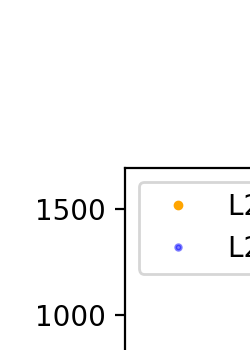

In [55]:
%matplotlib notebook
f, axarr = plt.subplots(3, sharex=True, sharey=False,figsize=(5,7))
axarr[0].plot(spikes_with_t[0], spikes_with[0],'o',markersize=2.5,color='orange',alpha=1,label='L23EXC with spike')
axarr[0].plot(spikes_without_t[0], spikes_without[0],'o',markersize=2,color='b',alpha=0.5,label='L23EXC without spike')
axarr[1].plot(spikes_with_t[1], spikes_with[1],'o',markersize=2.5,color='orange',alpha=1,label='L23NFS with spike')
axarr[1].plot(spikes_without_t[1], spikes_without[1],'o',markersize=2,color='b',alpha=0.5,label='L23NFS without spike')
axarr[2].plot(spikes_with_t[2], spikes_with[2],'o',markersize=1.5,color='orange',alpha=1,label='L23FS with spike')
axarr[2].plot(spikes_without_t[2], spikes_without[2],'o',markersize=1,color='b',alpha=0.5,label='L23FS without spike')
axarr[2].set_xlabel('Time (s)')
axarr[2].set_ylabel('Neuron indices')

axarr[0].set_ylim(0,1692)
axarr[1].set_ylim(-5,163)
axarr[2].set_ylim(0,105)

# Bring subplots close to each other.
f.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
axarr[1].ylim = 5
for ax in axarr:
    ax.label_outer()
    ax.legend(loc=2)


In [56]:
f.savefig('../figs/changes_spikel23_exp.jpg')

In [ ]:
fig_2= plt.figure(figsize=(10,5))

b2tools.plot_synapses(conn['L4exc_L4exc'].i,conn['L4exc_L4exc'].j,marker='.')

In [ ]:
layer = 0
neuron_no = 10

fig_si = plt.figure(figsize=(9,4))
time = rec_v['L4fs'].t
volts = rec_v_without[layer][neuron_no]*b2.volt
volts2 = rec_v_with[layer][neuron_no]*b2.volt
for i in spikes_without_t[layer][spikes_without[layer]==neuron_no]:
    index = int(i/b2.ms*10)
    volts[index] = 40*b2.mV

for i in spikes_with_t[layer][spikes_with[layer]==neuron_no]:
    index = int(i/b2.ms*10)
    volts2[index] = 40*b2.mV
    
withoutspike = plt.plot(time,volts,alpha=0.5,color='b',label='without spike')
withspike = plt.plot(time,volts2,alpha=0.5,color='orange',label='with 1 extra spike')
plt.legend(loc=2)
plt.xlabel('time (s)')
plt.ylabel('membrane potential (mV) for neuron where spike was added')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
fig_si.savefig('../figs/l23oneneuron10.jpg')


In [ ]:
neuron_no = 10

#l4exc_l4exc
source_indices_L23exc_L23fs = np.where(np.array(conn_L23exc_L23fs.i)==neuron_no)
target_indices_L23exc_L23fs = np.array(conn_L23exc_L23fs.j)[source_indices_L23exc_L23fs]

In [ ]:
source_indices_L23fs_L23exc = np.where(np.array(conn_L23exc_L23fs.i)==29)
target_indices_L23fs_L23exc = np.array(conn_L23fs_L23exc.j)[source_indices_L23fs_L23exc]

In [ ]:
target_indices_L23fs_L23exc

Remember : 
- 0 : L23exc
- 1 : L23 nfs
- 2 : L23 fs
- 3 : L4 exc
- 4 : L4 nfs
- 5 : L4 fs

In [ ]:
layer = 2
neuron_no = 29

fig_si = plt.figure(figsize=(9,4))
time = rec_v['L4fs'].t
volts = rec_v_without[layer][neuron_no]*b2.volt
volts2 = rec_v_with[layer][neuron_no]*b2.volt
for i in spikes_without_t[layer][spikes_without[layer]==neuron_no]:
    index = int(i/b2.ms*10)
    volts[index] = 40*b2.mV

for i in spikes_with_t[layer][spikes_with[layer]==neuron_no]:
    index = int(i/b2.ms*10)
    volts2[index] = 40*b2.mV
    
withoutspike = plt.plot(time,volts,alpha=0.5,color='b',label='without spike')
withspike = plt.plot(time,volts2,alpha=0.5,color='orange',label='with 1 extra spike')
plt.legend(loc=2)
plt.xlabel('time (s)')
plt.ylabel('Vm (mV) for a L4fs neuron')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
fig_si.savefig('../figs/l23no18.jpg')

In [ ]:
with_spikearray = spikes_with_t[layer][spikes_with[layer]==neuron_no]

In [ ]:
without_spikearray = spikes_without_t[layer][spikes_without[layer]==neuron_no]

In [ ]:
with_spikearray

In [ ]:
fig_hist = plt.figure()
plt.hist(with_spikearray, bins = np.arange(0,1.5,0.01),color='orange',alpha = 0.5);
plt.hist(without_spikearray, bins = np.arange(0,1.5,0.01),color = 'b',alpha = 0.5);

In [ ]:
fig_hist_all = plt.figure()

plt.hist(spikes_with_t[layer], bins = np.arange(0,1.5,0.01),color='orange',alpha = 0.5);
plt.hist(spikes_without_t[layer], bins = np.arange(0,1.5,0.01),color='b',alpha = 0.5);

In [ ]:
# fig_si.savefig('../figs/analysis_downstreamL23_2_expanded.jpg')


In [ ]:
#{'L23': {'exc': 1691, 'nfs': 162, 'fs': 101}, 'L4': {'exc': 1656, 'nfs': 28, 'fs': 87}} 

n = 2

binsize = 100
matwith = np.zeros(shape=(1691,15000))
matwithout = np.zeros(shape=(1691,15000))

timearray_w = spikes_with_t[n]*10000
timearray_w = timearray_w.astype(int)

timearray_wo = spikes_without_t[n]*10000
timearray_wo = timearray_wo.astype(int)

for f,b in zip(spikes_with[n],timearray_w):
    matwith[f,b] = 1

for f,b in zip(spikes_without[n],timearray_wo):
    matwithout[f,b] = 1

matwithbin = np.zeros(shape=(1691,np.int(15000/binsize)))
matwithoutbin = np.zeros(shape=(1691,np.int(15000/binsize)))

In [ ]:
for i in np.arange(0,1691,1):
    for time in np.arange(0,15000,binsize):
#         print('with :',time,np.sum(matwith[i,time:time+binsize]))
        matwithbin[i,np.int(time/binsize)] =  np.sum(matwith[i,time:time+binsize])
#         print('without :',time,np.sum(matwithout[i,time:time+binsize]))
        matwithoutbin[i,np.int(time/binsize)] = np.sum(matwithout[i,time:time+binsize])

size1=[39,1041,1013,210,489,897] #spikecounts
size2=[39,1044,1016,210,488,896] 

size = [sum(x) for x in zip(size1,size2)]

In [ ]:
size[:] = [int(x/2) for x in size]

In [ ]:
tempmat = np.abs(matwithbin-matwithoutbin)
tempmat[tempmat > 0] = 1
print(np.sum(tempmat)/size[n])

### Removing L4 fs connections

In [ ]:
b2.start_scope()
pops_net2.restore('nospike')

conn['L4fs_L4fs'].w = 0
conn['L4fs_L4exc'].w = 0
pops_net2.run(500*b2.ms, report = 'text')

print(np.shape(np.array(spikes['L23exc'].i)))
print(np.shape(np.array(spikes['L23nfs'].i)))
print(np.shape(np.array(spikes['L23fs'].i)))
print(np.shape(np.array(spikes['L4exc'].i)))
print(np.shape(np.array(spikes['L4nfs'].i)))
print(np.shape(np.array(spikes['L4fs'].i)))

In [ ]:
spikes_noL4fs = [np.array(spikes['L23exc'].i),\
                  np.array(spikes['L23nfs'].i),\
                  np.array(spikes['L23fs'].i),\
                  np.array(spikes['L4exc'].i),\
                  np.array(spikes['L4nfs'].i),\
                  np.array(spikes['L4fs'].i)]

spikes_noL4fs_t = [np.array(spikes['L23exc'].t),\
                  np.array(spikes['L23nfs'].t),\
                  np.array(spikes['L23fs'].t),\
                  np.array(spikes['L4exc'].t),\
                  np.array(spikes['L4nfs'].t),\
                  np.array(spikes['L4fs'].t)]

rec_v_noL4fs = [np.array(rec_v['L23exc'].v),\
                  np.array(rec_v['L23nfs'].v),\
                  np.array(rec_v['L23fs'].v),\
                  np.array(rec_v['L4exc'].v),\
                  np.array(rec_v['L4nfs'].v),\
                  np.array(rec_v['L4fs'].v)]

In [ ]:
%matplotlib notebook
f2, axarr2 = plt.subplots(6, sharex=True, sharey=False,figsize=(5,7))
axarr2[0].plot(spikes_noL4fs_t[0], spikes_noL4fs[0],'o',markersize=2.5,color='orange',alpha=1,label='L23EXC with noL4fs')
axarr2[0].plot(spikes_without_t[0], spikes_without[0],'o',markersize=2,color='b',alpha=0.5,label='L23EXC without spike')
axarr2[1].plot(spikes_noL4fs_t[1], spikes_noL4fs[1],'o',markersize=2.5,color='orange',alpha=1,label='L23NFS with noL4fs')
axarr2[1].plot(spikes_without_t[1], spikes_without[1],'o',markersize=2,color='b',alpha=0.5,label='L23NFS without spike')
axarr2[2].plot(spikes_noL4fs_t[2], spikes_noL4fs[2],'o',markersize=1.5,color='orange',alpha=1,label='L23FS with noL4fse')
axarr2[2].plot(spikes_without_t[2], spikes_without[2],'o',markersize=1,color='b',alpha=0.5,label='L23FS without spike')
axarr2[3].plot(spikes_noL4fs_t[3], spikes_noL4fs[3],'o',markersize=2.5,color='orange',alpha=1,label='L4EXC with noL4fs')
axarr2[3].plot(spikes_without_t[3], spikes_without[3],'o',markersize=2,color='b',alpha=0.5,label='L4EXC without spike')
axarr2[4].plot(spikes_noL4fs_t[4], spikes_noL4fs[4],'o',markersize=2.5,color='orange',alpha=1,label='L4NFS with noL4fs')
axarr2[4].plot(spikes_without_t[4], spikes_without[4],'o',markersize=2,color='b',alpha=0.5,label='L4NFS without spike')
axarr2[5].plot(spikes_noL4fs_t[5], spikes_noL4fs[5],'o',markersize=1.5,color='orange',alpha=1,label='L4FS with noL4fs')
axarr2[5].plot(spikes_without_t[5], spikes_without[5],'o',markersize=1,color='b',alpha=0.5,label='L4FS without spike')
axarr2[5].set_xlabel('Time (s)')
axarr2[2].set_ylabel('Neuron indices')

axarr2[0].set_ylim(0,1692)
axarr2[1].set_ylim(-5,163)
axarr2[2].set_ylim(0,105)
axarr2[3].set_ylim(0,1657)
axarr2[4].set_ylim(0,29)
axarr2[5].set_ylim(0,88)

# Bring subplots close to each other.
f2.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
axarr2[1].ylim = 5
for ax in axarr2:
    ax.label_outer()
    ax.legend(loc=2)


### Removing all the connections

In [ ]:
b2.start_scope()
pops_net2.restore('nospike')

conn['L4fs_L4fs'].w = 0
conn['L4fs_L4exc'].w = 0
conn['L4exc_L4fs'].w = 0
conn['L4nfs_L4fs'].w = 0
pops_net2.run(500*b2.ms, report = 'text')

print(np.shape(np.array(spikes['L23exc'].i)))
print(np.shape(np.array(spikes['L23nfs'].i)))
print(np.shape(np.array(spikes['L23fs'].i)))
print(np.shape(np.array(spikes['L4exc'].i)))
print(np.shape(np.array(spikes['L4nfs'].i)))
print(np.shape(np.array(spikes['L4fs'].i)))

In [ ]:
spikes_noL4fs_0 = [np.array(spikes['L23exc'].i),\
                  np.array(spikes['L23nfs'].i),\
                  np.array(spikes['L23fs'].i),\
                  np.array(spikes['L4exc'].i),\
                  np.array(spikes['L4nfs'].i),\
                  np.array(spikes['L4fs'].i)]

spikes_noL4fs_t_0 = [np.array(spikes['L23exc'].t),\
                  np.array(spikes['L23nfs'].t),\
                  np.array(spikes['L23fs'].t),\
                  np.array(spikes['L4exc'].t),\
                  np.array(spikes['L4nfs'].t),\
                  np.array(spikes['L4fs'].t)]

rec_v_noL4fs_0 = [np.array(rec_v['L23exc'].v),\
                  np.array(rec_v['L23nfs'].v),\
                  np.array(rec_v['L23fs'].v),\
                  np.array(rec_v['L4exc'].v),\
                  np.array(rec_v['L4nfs'].v),\
                  np.array(rec_v['L4fs'].v)]

In [ ]:
%matplotlib notebook
f3, axarr3 = plt.subplots(6, sharex=True, sharey=False,figsize=(5,7))
axarr3[0].plot(spikes_noL4fs_t_0[0], spikes_noL4fs_0[0],'o',markersize=2.5,color='orange',alpha=1,label='L23EXC with noL4fs_0')
axarr3[0].plot(spikes_without_t[0], spikes_without[0],'o',markersize=2,color='b',alpha=0.5,label='L23EXC without spike')
axarr3[1].plot(spikes_noL4fs_t_0[1], spikes_noL4fs_0[1],'o',markersize=2.5,color='orange',alpha=1,label='L23NFS with noL4fs_0')
axarr3[1].plot(spikes_without_t[1], spikes_without[1],'o',markersize=2,color='b',alpha=0.5,label='L23NFS without spike')
axarr3[2].plot(spikes_noL4fs_t_0[2], spikes_noL4fs_0[2],'o',markersize=1.5,color='orange',alpha=1,label='L23FS with noL4fse_0')
axarr3[2].plot(spikes_without_t[2], spikes_without[2],'o',markersize=1,color='b',alpha=0.5,label='L23FS without spike')
axarr3[3].plot(spikes_noL4fs_t_0[3], spikes_noL4fs_0[3],'o',markersize=2.5,color='orange',alpha=1,label='L4EXC with noL4fs_0')
axarr3[3].plot(spikes_without_t[3], spikes_without[3],'o',markersize=2,color='b',alpha=0.5,label='L4EXC without spike')
axarr3[4].plot(spikes_noL4fs_t_0[4], spikes_noL4fs_0[4],'o',markersize=2.5,color='orange',alpha=1,label='L4NFS with noL4fs_0')
axarr3[4].plot(spikes_without_t[4], spikes_without[4],'o',markersize=2,color='b',alpha=0.5,label='L4NFS without spike')
axarr3[5].plot(spikes_noL4fs_t_0[5], spikes_noL4fs_0[5],'o',markersize=1.5,color='orange',alpha=1,label='L4FS with noL4fs_0')
axarr3[5].plot(spikes_without_t[5], spikes_without[5],'o',markersize=1,color='b',alpha=0.5,label='L4FS without spike')
axarr3[5].set_xlabel('Time (s)')
axarr3[2].set_ylabel('Neuron indices')

axarr3[0].set_ylim(0,1692)
axarr3[1].set_ylim(-5,163)
axarr3[2].set_ylim(0,105)
axarr3[3].set_ylim(0,1657)
axarr3[4].set_ylim(0,29)
axarr3[5].set_ylim(0,88)

# Bring subplots close to each other.
f3.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
axarr3[1].ylim = 5
for ax in axarr3:
    ax.label_outer()
    ax.legend(loc=2)


### Putting in a Spike Generator

In [ ]:
b2.start_scope()
pops_net2.restore('nospike')

indices = spikes_with[5][np.argmax(spikes_without_t[5]>1.0):]
times = spikes_with_t[5][np.argmax(spikes_without_t[5]>1.0):]*b2.second
new_L4fs = b2.SpikeGeneratorGroup(87, indices, times)

newconn_L4fs_L4exc = b2.Synapses(new_L4fs, pops['L4exc'], 'w : siemens', on_pre = 'g_inh+=w')
newconn_L4fs_L4exc.connect(i = np.array(conn_L4fs_L4exc.i), j = np.array(conn_L4fs_L4exc.j))
newconn_L4fs_L4exc.w = preprocessing.CUBA_to_COBA(-params.conn_param['L4_L4']['fs_exc']['w']*b2.nA, v_rest_1, E_inh)

pops_net2.add(new_L4fs,newconn_L4fs_L4exc)

conn['L4fs_L4fs'].w = 0
conn['L4fs_L4exc'].w = 0
conn['L4exc_L4fs'].w = 0
conn['L4nfs_L4fs'].w = 0

pops_net2.store('spikegenadded')

pops_net2.run(500*b2.ms, report = 'text')

print(np.shape(np.array(spikes['L23exc'].i)))
print(np.shape(np.array(spikes['L23nfs'].i)))
print(np.shape(np.array(spikes['L23fs'].i)))
print(np.shape(np.array(spikes['L4exc'].i)))
print(np.shape(np.array(spikes['L4nfs'].i)))
print(np.shape(np.array(spikes['L4fs'].i)))

In [ ]:
spikes_genL4fs = [np.array(spikes['L23exc'].i),\
                  np.array(spikes['L23nfs'].i),\
                  np.array(spikes['L23fs'].i),\
                  np.array(spikes['L4exc'].i),\
                  np.array(spikes['L4nfs'].i),\
                  np.array(spikes['L4fs'].i)]

spikes_genL4fs_t = [np.array(spikes['L23exc'].t),\
                  np.array(spikes['L23nfs'].t),\
                  np.array(spikes['L23fs'].t),\
                  np.array(spikes['L4exc'].t),\
                  np.array(spikes['L4nfs'].t),\
                  np.array(spikes['L4fs'].t)]

rec_v_genL4fs = [np.array(rec_v['L23exc'].v),\
                  np.array(rec_v['L23nfs'].v),\
                  np.array(rec_v['L23fs'].v),\
                  np.array(rec_v['L4exc'].v),\
                  np.array(rec_v['L4nfs'].v),\
                  np.array(rec_v['L4fs'].v)]

In [ ]:
%matplotlib notebook
f4, axarr4 = plt.subplots(6, sharex=True, sharey=False,figsize=(5,7))
axarr4[0].plot(spikes_genL4fs_t[0], spikes_genL4fs[0],'o',markersize=2.5,color='orange',alpha=1,label='L23EXC with genL4fs')
axarr4[0].plot(spikes_with_t[0], spikes_with[0],'o',markersize=2,color='b',alpha=0.5,label='L23EXC without spike')
axarr4[1].plot(spikes_genL4fs_t[1], spikes_genL4fs[1],'o',markersize=2.5,color='orange',alpha=1,label='L23NFS with genL4fs')
axarr4[1].plot(spikes_with_t[1], spikes_with[1],'o',markersize=2,color='b',alpha=0.5,label='L23NFS without spike')
axarr4[2].plot(spikes_genL4fs_t[2], spikes_genL4fs[2],'o',markersize=1.5,color='orange',alpha=1,label='L23FS with genL4fs')
axarr4[2].plot(spikes_with_t[2], spikes_with[2],'o',markersize=1,color='b',alpha=0.5,label='L23FS without spike')
axarr4[3].plot(spikes_genL4fs_t[3], spikes_genL4fs[3],'o',markersize=2.5,color='orange',alpha=1,label='L4EXC with genL4fs')
axarr4[3].plot(spikes_with_t[3], spikes_with[3],'o',markersize=2,color='b',alpha=0.5,label='L4EXC without spike')
axarr4[4].plot(spikes_genL4fs_t[4], spikes_genL4fs[4],'o',markersize=2.5,color='orange',alpha=1,label='L4NFS with genL4fs')
axarr4[4].plot(spikes_with_t[4], spikes_with[4],'o',markersize=2,color='b',alpha=0.5,label='L4NFS without spike')
axarr4[5].plot(spikes_with_t[5], spikes_with[5],'o',markersize=1.5,color='orange',alpha=1,label='L4FS with genL4fs')
axarr4[5].plot(spikes_with_t[5], spikes_with[5],'o',markersize=1,color='b',alpha=0.5,label='L4FS without spike')
axarr4[5].set_xlabel('Time (s)')
axarr4[2].set_ylabel('Neuron indices')

axarr4[0].set_ylim(0,1692)
axarr4[1].set_ylim(-5,163)
axarr4[2].set_ylim(0,105)
axarr4[3].set_ylim(0,1657)
axarr4[4].set_ylim(0,29)
axarr4[5].set_ylim(0,88)

# Bring subplots close to each other.
f4.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
axarr4[1].ylim = 5
for ax in axarr4:
    ax.label_outer()
    ax.legend(loc=2)
